<a href="https://colab.research.google.com/github/abhaysaxena1904/Practice/blob/main/Gesture_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gesture Recognition

> Indented block


In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

Submitted by: Shibesh Kumar Chand & Abhay Saxena

In [ ]:
import numpy as np
import os
#from scipy.misc import imread, imresize
import datetime
import os
import cv2
import matplotlib.pyplot as plt
import imageio

In [ ]:
import warnings
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [ ]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)

In [ ]:
# mounting the google drive

from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Unzipping the data set uploaded to gdrive

!unzip /content/gdrive/MyDrive/Data_Sets/GestureRecognition/Project_data.zip

Streaming output truncated to the last 5000 lines.
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00050.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00052.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00054.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00056.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00058.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00060.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00062.png  
   creating: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/
 extracting: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/WIN_20180926_17_35_12_Pro_00001.png  
 extracting: Project_data/t

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
train_doc = np.random.permutation(open('/content/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/Project_data/val.csv').readlines())

In [ ]:
val_doc

array(['WIN_20180926_17_24_20_Pro_Thumbs_Down_new;Thumbs_Down_new;3\n',
       'WIN_20180907_15_54_30_Pro_Thumbs Up_new;Thumbs Up_new;4\n',
       'WIN_20180926_17_08_11_Pro_Stop_new;Stop_new;2\n',
       'WIN_20180925_18_01_40_Pro_Left_Swipe_new;Left_Swipe_new;0\n',
       'WIN_20180907_16_16_48_Pro_Stop Gesture_new;Stop Gesture_new;2\n',
       'WIN_20180907_16_33_15_Pro_Thumbs Down_new;Thumbs Down_new;3\n',
       'WIN_20180926_16_46_22_Pro_Left_Swipe_new;Left_Swipe_new;0\n',
       'WIN_20180907_16_25_44_Pro_Stop Gesture_new;Stop Gesture_new;2\n',
       'WIN_20180926_17_05_38_Pro_Thumbs_Down_new;Thumbs_Down_new;3\n',
       'WIN_20180907_15_55_06_Pro_Right Swipe_new;Right Swipe_new;1\n',
       'WIN_20180926_16_57_50_Pro_Thumbs_Down_new;Thumbs_Down_new;3\n',
       'WIN_20180926_17_24_12_Pro_Right_Swipe_new;Right_Swipe_new;1\n',
       'WIN_20180907_15_57_43_Pro_Right Swipe_new;Right Swipe_new;1\n',
       'WIN_20180926_17_05_38_Pro_Left_Swipe_new;Left_Swipe_new;0\n',
       'WIN_

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    #img_idx = [11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28] #create a list of image numbers you want to use for a particular video
    img_idx =[i for i in range(0,29)]
                                                                  
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image = image.resize(120,120)
                    batch_data[folder,idx,:,:,0] /= 255
                    batch_data[folder,idx,:,:,1] /= 255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] /= 255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,len(img_idx),120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = image.resize(120,120)
                    batch_data[folder,idx,:,:,0] /= 255
                    batch_data[folder,idx,:,:,1] /= 255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] /= 255 #normalise and feed in the image
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
train_path = '/content/Project_data/train'
val_path = '/content/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # number of epochs
print ('# epochs =', num_epochs)
batch_size = 20 # batch size
print ('# batch size =', batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 20
# batch size = 20


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout
#write your model here

############### Don't Run Model 1 , run from Model 2 onwards ###################

**Model 1:**
  
  Conv3D + MaxPooling3D

  No. of Epochs:20

  Batch Size: 20

In [ ]:
Input_shape = (30, 120, 120, 3)
model_1 = Sequential()
model_1.add(Conv3D(16, (3,3,3), padding='same', input_shape=Input_shape))
model_1.add(Activation('relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling3D(pool_size=(2, 2,2)))

model_1.add(Conv3D(32, (3, 3,3), padding='same'))
model_1.add(Activation('relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling3D(pool_size=(2, 2,2)))

model_1.add(Conv3D(64, (3, 3,3), padding='same'))
model_1.add(Activation('relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling3D(pool_size=(2, 2,2)))

model_1.add(Conv3D(128, (3, 3,3), padding='same'))
model_1.add(Activation('relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling3D(pool_size=(2, 2,2)))

model_1.add(Flatten())
model_1.add(Dense(65))
model_1.add(Activation('relu'))
model_1.add(BatchNormalization())
model_1.add(Dropout(0.5))
model_1.add(Dense(5))
model_1.add(Activation('relu'))
model_1.add(BatchNormalization())
model_1.add(Activation('softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = optimizers.Adam(lr=0.001) #write your optimizer
model_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_1 (Activation)    (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 60, 60, 32)    1

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
curr_dt_time = datetime.datetime.now()
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
history1 = model_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - 1069s 31s/step - loss: 1.6096 - categorical_accuracy: 0.1759 - val_loss: 1.6092 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2021-06-1318_00_37.620191/model-00001-1.60956-0.19608-1.60920-0.23000.h5
Epoch 2/20
34/34 [==============================] - 195s 6s/step - loss: 1.6085 - categorical_accuracy: 0.2355 - val_loss: 1.6075 - val_categorical_accuracy: 0.2500

Epoch 00002: saving model to model_init_2021-06-1318_00_37.620191/model-00002-1.60796-0.29412-1.60749-0.25000.h5
Epoch 3/20
34/34 [==============================] - 191s 6s/step - loss: 1.6127 - categorical_accuracy: 0.1255 - val_loss: 1.6070 - val_categorical_accuracy: 0.2300

Epoch 00003: saving model to model_init_2021-06-1318_00_37.620191/model-00003-1.61079-0.17647-1.60697-0.23000.h5
Epoch 4/20
34/34 [==============================] - 199s 6s/step - loss: 1.6092 - categorical_accura

In [ ]:
# function to plot the train/val accuracies and losses.

def drawplot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

drawplot(history1)

######################################################################################################## Run from Below  ######################################

**Model 2:**
  
  Conv3D + MaxPooling3D

  No. of Epochs:40

  Batch Size: 50

  Adding more layers

In [ ]:
num_epochs = 40
print ('# epochs =', num_epochs)
batch_size = 50
print ('# Batch Size =', batch_size)

# epochs = 40
# Batch Size = 50


In [ ]:
Input_shape = (18, 120, 120, 3)
model_2 = Sequential()
model_2.add(Conv3D(8, (3,3,3), padding='same', input_shape=Input_shape))
model_2.add(Activation('relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling3D(pool_size=(2,2,2)))

model_2.add(Conv3D(16, (3,3,3), padding='same'))
model_2.add(Activation('relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling3D(pool_size=(2,2,2)))

model_2.add(Conv3D(32, (3,3,3), padding='same'))
model_2.add(Activation('relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling3D(pool_size=(2,2,2)))

model_2.add(Conv3D(64, (3,3,3), padding='same'))
model_2.add(Activation('relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling3D(pool_size=(2,2,2)))

#model_2.add(Conv3D(128, (3,3,3), padding='same'))
#model_2.add(Activation('relu'))
#model_2.add(BatchNormalization())
#model_2.add(MaxPooling3D(pool_size=(2,2,2)))

model_2.add(Flatten())
model_2.add(Dense(65))
model_2.add(Activation('relu'))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.5))
model_2.add(Dense(5))
model_2.add(Activation('relu'))
model_2.add(BatchNormalization())
model_2.add(Activation('softmax'))

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
optimiser = optimizers.Adam(lr=0.002)
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 18, 120, 120, 8)   656       
_________________________________________________________________
activation_7 (Activation)    (None, 18, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 18, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 9, 60, 60, 8)      0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 9, 60, 60, 16)     3472      
_________________________________________________________________
activation_8 (Activation)    (None, 9, 60, 60, 16)     0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 9, 60, 60, 16)    

In [ ]:
curr_dt_time = datetime.datetime.now()
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history2 = model_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 50
Epoch 1/40
14/14 [==============================] - 659s 47s/step - loss: 1.6094 - categorical_accuracy: 0.2179 - val_loss: 1.6090 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2021-06-1319_19_46.239094/model-00001-1.60955-0.20362-1.60903-0.23000.h5
Epoch 2/40
14/14 [==============================] - 211s 15s/step - loss: 1.6084 - categorical_accuracy: 0.2546 - val_loss: 1.6080 - val_categorical_accuracy: 0.2800

Epoch 00002: saving model to model_init_2021-06-1319_19_46.239094/model-00002-1.60918-0.24176-1.60800-0.28000.h5
Epoch 3/40
14/14 [==============================] - 211s 15s/step - loss: 1.6116 - categorical_accuracy: 0.1198 - val_loss: 1.6087 - val_categorical_accuracy: 0.2300

Epoch 00003: saving model to model_init_2021-06-1319_19_46.239094/model-00003-1.61056-0.16484-1.60874-0.23000.h5
Epoch 4/40
14/14 [==============================] - 210s 15s/step - loss: 1.6090 - categorical_accu

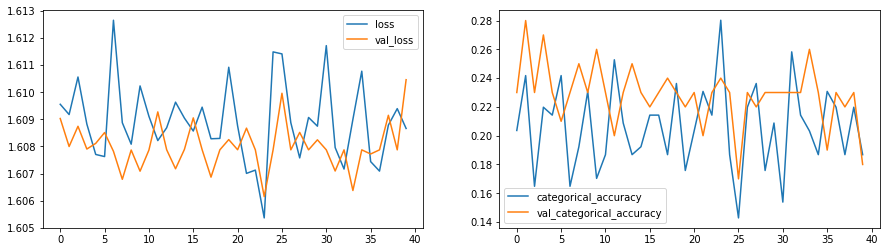

In [ ]:
# plotting result

drawplot(history2)

#####################################################################################

**Model 3:**
  
  Conv3D + MaxPooling3D

  No. of Epochs:40

  Batch Size: 50

Reduce filter size to (2,2,2) 

In [ ]:
num_epochs = 40
print ('# epochs =', num_epochs)
batch_size = 50
print ('# Batch Size =', batch_size)

# epochs = 40
# Batch Size = 50


In [ ]:
Input_shape = (18, 120, 120, 3)
model_3 = Sequential()
model_3.add(Conv3D(8, (2,2,2), padding='same', input_shape=Input_shape))
model_3.add(Activation('relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling3D(pool_size=(2,2,2)))

model_3.add(Conv3D(16, (2,2,2), padding='same'))
model_3.add(Activation('relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling3D(pool_size=(2,2,2)))

model_3.add(Conv3D(32, (2,2,2), padding='same'))
model_3.add(Activation('relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling3D(pool_size=(2,2,2)))

model_3.add(Conv3D(64, (2,2,2), padding='same'))
model_3.add(Activation('relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling3D(pool_size=(2,2,2)))

#model_2.add(Conv3D(128, (3,3,3), padding='same'))
#model_2.add(Activation('relu'))
#model_2.add(BatchNormalization())
#model_2.add(MaxPooling3D(pool_size=(2,2,2)))

model_3.add(Flatten())
model_3.add(Dense(65))
model_3.add(Activation('relu'))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.5))
model_3.add(Dense(5))
model_3.add(Activation('relu'))
model_3.add(BatchNormalization())
model_3.add(Activation('softmax'))

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
optimiser = optimizers.Adam(lr=0.001)
model_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 18, 120, 120, 8)   200       
_________________________________________________________________
activation_14 (Activation)   (None, 18, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 18, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 9, 60, 60, 8)      0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 9, 60, 60, 16)     1040      
_________________________________________________________________
activation_15 (Activation)   (None, 9, 60, 60, 16)     0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 9, 60, 60, 16)    

In [ ]:
curr_dt_time = datetime.datetime.now()
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history3 = model_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
# plotting result

drawplot(history3)

#####################################################################################

**Model 4:**
  
Conv3D + MaxPooling3D

No. of Epochs:40

Batch Size: 50

Reduce filter size to (2,2,2) 

Adaleta Optimizer

In [ ]:
Input_shape = (18, 120, 120, 3)
model_4 = Sequential()
model_4.add(Conv3D(8, (2,2,2), padding='same', input_shape=Input_shape))
model_4.add(Activation('relu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling3D(pool_size=(2,2,2)))

model_4.add(Conv3D(16, (2,2,2), padding='same'))
model_4.add(Activation('relu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling3D(pool_size=(2,2,2)))

model_4.add(Conv3D(32, (2,2,2), padding='same'))
model_4.add(Activation('relu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling3D(pool_size=(2,2,2)))

model_4.add(Conv3D(64, (2,2,2), padding='same'))
model_4.add(Activation('relu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling3D(pool_size=(2,2,2)))

model_4.add(Flatten())
model_4.add(Dense(65))
model_4.add(Activation('relu'))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.5))
model_4.add(Dense(5))
model_4.add(Activation('relu'))
model_4.add(BatchNormalization())
model_4.add(Activation('softmax'))

optimiser = optimizers.Adadelta()
model_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_4.summary())

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
curr_dt_time = datetime.datetime.now()
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history4 = model_4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
# plotting result

drawplot(history4)

**Model 4:**
  
Conv3D + MaxPooling3D

No. of Epochs:40

Batch Size: 30

filter size (2,2,2) 

Dropout 0.25

Adam Optimizer lr = 0.0002

In [ ]:
num_epochs = 40
print ('# epochs =', num_epochs)
batch_size = 30
print ('# Batch Size =', batch_size)

In [ ]:
Input_shape = (30, 120, 120, 3)
model_5 = Sequential()
model_5.add(Conv3D(16, (2,2,2), padding='same', input_shape=Input_shape))
model_5.add(Activation('relu'))
model_5.add(BatchNormalization())
model_5.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_5.add(Conv3D(32, (2,2,2), padding='same'))
model_5.add(Activation('relu'))
model_5.add(BatchNormalization())
model_5.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_5.add(Conv3D(64, (2,2,2), padding='same'))
model_5.add(Activation('relu'))
model_5.add(BatchNormalization())
model_5.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_5.add(Conv3D(128, (2,2,2), padding='same'))
model_5.add(Activation('relu'))
model_5.add(BatchNormalization())
model_5.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_5.add(Flatten())
model_5.add(Dense(65))
model_5.add(Activation('relu'))
model_5.add(BatchNormalization())
model_5.add(Dropout(0.5))
model_5.add(Dense(5))
model_5.add(Activation('relu'))
model_5.add(BatchNormalization())
model_5.add(Activation('softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model_5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_5.summary())

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
curr_dt_time = datetime.datetime.now()
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history5 = model_5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
# plotting result

drawplot(history5)

################################################################################

In [ ]:
Input_shape = (30, 120, 120, 3)
model_6 = Sequential()
model_6.add(Conv3D(8, (2,2,2), padding='same', input_shape=Input_shape))
model_6.add(Activation('relu'))
model_6.add(BatchNormalization())
model_6.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_6.add(Conv3D(16, (2,2,2), padding='same'))
model_6.add(Activation('relu'))
model_6.add(BatchNormalization())
model_6.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_6.add(Conv3D(32, (2,2,2), padding='same'))
model_6.add(Activation('relu'))
model_6.add(BatchNormalization())
model_6.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_6.add(Conv3D(64, (2,2,2), padding='same'))
model_6.add(Activation('relu'))
model_6.add(BatchNormalization())
model_6.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_6.add(Flatten())
model_6.add(Dense(65))
model_6.add(Activation('relu'))
model_6.add(BatchNormalization())
model_6.add(Dropout(0.25))
model_6.add(Dense(5))
model_6.add(Activation('relu'))
model_6.add(BatchNormalization())
model_6.add(Activation('softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model_6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_6.summary())

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
curr_dt_time = datetime.datetime.now()
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history6 = model_6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
# plotting result

drawplot(history6)

################################################################################

In [ ]:
num_epochs = 40
print ('# epochs =', num_epochs)
batch_size = 30
print ('# Batch Size =', batch_size)

In [ ]:
Input_shape=(30,120,120,3)
model_7 = Sequential()
model_7.add(Conv3D(8,(3,3,3), input_shape=Input_shape,padding='same'))
model_7.add(BatchNormalization())
model_7.add(Activation('relu'))
model_7.add(MaxPooling3D(pool_size=(2,2,2)))

model_7.add(Conv3D(16,(3,3,3),padding='same'))
model_7.add(BatchNormalization())
model_7.add(Activation('relu'))
model_7.add(MaxPooling3D(pool_size=(2,2,2)))

model_7.add(Conv3D(32,(1,3,3), padding='same'))
model_7.add(BatchNormalization())
model_7.add(Activation('relu'))
model_7.add(MaxPooling3D(pool_size=(2,2,2)))

model_7.add(Conv3D(64,(1,3,3), padding='same'))
model_7.add(Activation('relu'))
model_7.add(Dropout(0.25))
model_7.add(MaxPooling3D(pool_size=(2,2,2)))

model_7.add(Flatten())
model_7.add(Dense(256, activation='relu'))
model_7.add(Dropout(0.5))
model_7.add(Dense(128, activation='relu'))
model_7.add(Dropout(0.5))
model_7.add(Dense(5, activation='softmax'))

optimiser = optimizers.Adam()
model_7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_7.summary())

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
curr_dt_time = datetime.datetime.now()
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history7 = model_7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
# Running the same model with bigger batch size
num_epochs = 40
print ('# epochs =', num_epochs)
batch_size = 50
print ('# Batch Size =', batch_size)

history7b = model_7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
# Running the same model with bigger batch size
num_epochs = 20
print ('# epochs =', num_epochs)
batch_size = 60
print ('# Batch Size =', batch_size)

history7c = model_7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

##################  Model 8   ###############

In [ ]:
from skimage.transform import resize

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    #img_idx = [11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28] #create a list of image numbers you want to use for a particular video
    img_idx =[i for i in range(0,29)]
                                                                  
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image = resize(image,(100,100))
                    batch_data[folder,idx,:,:,0] /= 255
                    batch_data[folder,idx,:,:,1] /= 255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] /= 255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,len(img_idx),100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize(image,(100,100))
                    batch_data[folder,idx,:,:,0] /= 255
                    batch_data[folder,idx,:,:,1] /= 255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] /= 255 #normalise and feed in the image
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels


In [ ]:
Input_shape=(30,100,100,3)
model_8 = Sequential()
model_8.add(Conv3D(8,(2,2,2), input_shape=Input_shape,padding='same'))
model_8.add(BatchNormalization())
model_8.add(Activation('relu'))
model_8.add(MaxPooling3D(pool_size=(2,2,2)))

model_8.add(Conv3D(16,(2,2,2),padding='same'))
model_8.add(BatchNormalization())
model_8.add(Activation('relu'))
model_8.add(MaxPooling3D(pool_size=(2,2,2)))

model_8.add(Conv3D(32,(2,2,2), padding='same'))
model_8.add(BatchNormalization())
model_8.add(Activation('relu'))
model_8.add(MaxPooling3D(pool_size=(2,2,2)))

model_8.add(Conv3D(64,(2,2,2), padding='same'))
model_8.add(BatchNormalization())
model_8.add(Activation('relu'))
model_8.add(MaxPooling3D(pool_size=(2,2,2)))

model_8.add(Flatten())
model_8.add(Dense(256, activation='relu'))
model_8.add(Dropout(0.5))
model_8.add(Dense(128, activation='relu'))
model_8.add(Dropout(0.5))
model_8.add(Dense(5, activation='softmax'))

optimiser = optimizers.Adam()
model_8.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_8.summary())

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
curr_dt_time = datetime.datetime.now()
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
# Running the same model with bigger batch size
num_epochs = 25
print ('# epochs =', num_epochs)
batch_size = 50
print ('# Batch Size =', batch_size)

history8 = model_8.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

### Model 9 ###